In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from sklearn.metrics import median_absolute_error
import matplotlib.pyplot as plt
import datetime

import plotly.graph_objects as go
import ipywidgets as widgets

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div class="container-fluid">
    <img src="https://cdn.tv-programme.com/pic/episodes/38/387767.jpg" class="center-block">
    <div class="carousel-caption">
        <div class="page-header">
          <h1><p style="text-align: center; font-size:50px; color:#FFFFFF">N-BEATS </p><small STYLE='color:#FFFFFF; font-size:30px' >NEURAL BASIS EXPANSION ANALYSIS FOR
        INTERPRETABLE TIME SERIES FORECASTING
        </small></h1></div></div>
</div>

<h1 style="background-color: #428bca; color:#FFFFFF">Introduction</h1>

We will see in this notebook an implementation of N-BEATS model with keras and application on 4 examples!

Based on [N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR INTERPRETABLE TIME SERIES FORECASTING](https://arxiv.org/abs/1905.10437)

> N-BEATS model is based on backward and forward residual links and a very deep stack of fully-connected layers. 
> Our architecture design methodology relies on a few key principles. First, the base architecture
should be simple and generic, yet expressive (deep). Second, the architecture should not rely on timeseries-specific feature engineering or input scaling. These prerequisites let us explore the potential
of pure DL architecture in TS forecasting. Finally, as a prerequisite to explore interpretability, the
architecture should be extendable towards making its outputs human interpretable. We now discuss
how those principles converge to the proposed architecture.

It has been declined in two versions: Generic model and interpretable model. The first one works as a black box while the second describe the series as a function of trend and seasonality. They give approximately same results but they offer better performance when coupled by bagging method.

We will demonstrate how to use the interpretable model (noted I) and how to tune it. Before dive into code details, let's focus on mathematics details and the overall structure.

<div class="alert alert-info" role="alert"> <a style="font-weight: bold;">Alert:</a> We slightly changed the implementation in order to integrate some additional stuffs.</div>



<h1 style="background-color: #428bca; color:#FFFFFF">Summary</h1>

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#a">I  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Overall structure </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#b">II &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Trend </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#c">III&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Seasonality </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#d">IV &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Generic </a></h3>

--- 

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#e">V  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#f">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 1: Temperature Change </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#g">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 2: Spotify </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#h">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 3: U.S gaz </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#i">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 4: Covid vaccination </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#j">VI &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conclusion </a></h3>

<h1 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Overall Structure </h1><a id=a></a>
<hr>

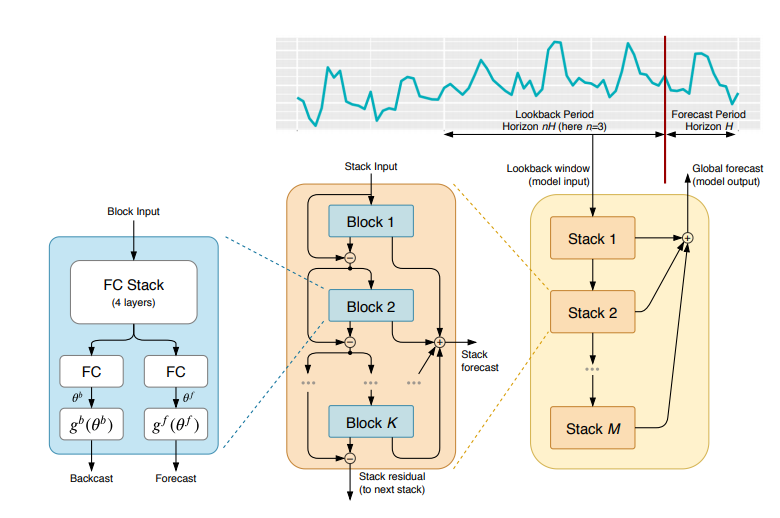 

<div class="alert alert-info" role="alert"> <a style="font-weight: bold;">Alert:</a> image taken from the research paper.</div>

<div class="panel panel-default">
   <div class="panel-heading">First, authors defined multiple loss functions:</div>
    <div class="panel-body"> <p>Open code to see them or click to get more informations.</p>
<div class="list-group">
  <a href="https://en.wikipedia.org/wiki/Mean_absolute_percentage_error#:~:text=The%20mean%20absolute%20percentage%20error%20(MAPE),%20also%20known,loss%20function%20for%20regression%20problems%20in%20machine%20learning" class="list-group-item">MAPE</a>
  <a href="https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error" class="list-group-item">SMAPE</a>
  <a href="https://en.wikipedia.org/wiki/Mean_absolute_scaled_error" class="list-group-item">MASE</a>
  <a href="https://arxiv.org/pdf/1905.10437.pdf" class="list-group-item">OWA</a>
</div></div></div>

In [ ]:
"""
The following functions are described in N-BEATS paper and have been used to train the model.
"""

def check_tensor(tensor):
    
    mask = tf.math.is_finite(tensor)
    new_tensor = tf.boolean_mask(tensor, mask, axis=None, name='boolean_mask')
    return new_tensor
    
def mape(y_true, y_pred):

    """
    Define the mean absolute percentage error.
    
        parameters
        ----------
        y_true : ndarray, DataFrame, list or Tensor.
            True values. 
        y_pred : ndarray, DataFrame, list or Tensor.
            Predicted values.

        returns
        -------
        error : Tensor
            Error of your model in %.
    """ 

    y_true = np.array(y_true, dtype='float32')
    y_pred = np.array(y_pred, dtype='float32')

    num = tf.abs(y_true - y_pred)
    den = tf.abs(y_true)
    
    results = check_tensor(num/den)
    
    error = 100 * tf.reduce_sum(results) / tf.dtypes.cast(tf.size(num), tf.float32)
    
    return error


def smape(y_true, y_pred):

    """
    Define the symmetric mean absolute percentage error.
    
        parameters
        ----------
        y_true : ndarray, DataFrame, list or Tensor.
            True values. 
        y_pred : ndarray, DataFrame, list or Tensor.
            Predicted values.

        returns
        -------
        error : Tensor
            Error of your model in %.
    """ 

    y_true = np.array(y_true, dtype='float32')
    y_pred = np.array(y_pred, dtype='float32')

    n = tf.abs(y_true - y_pred)
    d = tf.abs(y_true) +  tf.abs(y_pred)
    error = 200 * tf.reduce_sum(n/d) / tf.dtypes.cast(tf.size(n), tf.float32)
    
    return error


def mase(y_train, seasonality):
   
    """
    Define the Mean Absolute Scaled Error.
    whereas sMAPE scales the error by the average between the forecast and ground truth, the MASE
    scales by the average error of the naïve predictor that simply copies the observation measured m
    periods in the past, thereby accounting for seasonality.
    
        parameters
        ----------
        y_train : ndarray, DataFrame, list or Tensor.
            observed series history (Training values).
        seasonality: int
            Define the periodicity of the data. 
        y_true : ndarray, DataFrame, list or Tensor.
            True values. 
        y_pred : ndarray, DataFrame, list or Tensor.
            Predicted values.

        returns
        -------
        error : Tensor
            Error of your model in %.
    """ 
    
    def f(y_true, y_pred):
    
        y_true = np.array(y_true, dtype='float32')
        y_pred = np.array(y_pred, dtype='float32')
        y_t = np.array(y_train, dtype='float32')

        n = tf.abs(y_true - y_pred)
        y = tf.concat([y_t, y_true], 0)
        naive = tf.reduce_sum([tf.abs(y_front - y_back) for y_front, y_back in zip(y[seasonality+1:], y[:-seasonality])])
        d =  naive / (tf.dtypes.cast(tf.size(y), tf.float32)-seasonality)
        error =  tf.reduce_sum(n/d) / tf.dtypes.cast(tf.size(n), tf.float32)

        return error 
    return f


def owa(y_train, seasonality, smape_naive, mase_naive):

    """
    Define the overall weighted average. This is a M4-
    specific metric used to rank competition entries (M4 Team, 2018b), where sMAPE and MASE metrics
    are normalized such that a seasonally-adjusted naïve forecast obtains OWA = 1.0.

        parameters
        ----------
        y_train : ndarray, DataFrame, list or Tensor.
            observed series history (Training values).
        seasonality: int
            Define the periodicity of the data. 
        y_true : ndarray, DataFrame, list or Tensor.
            True values. 
        y_pred : ndarray, DataFrame, list or Tensor.
            Predicted values.

        returns
        -------
        error : Tensor
            Error of your model in %.
    """

    def f(y_true, y_pred):

        y_true = np.array(y_true, dtype='float32')
        y_pred = np.array(y_pred, dtype='float32')
        y_t = np.array(y_train, dtype='float32')

        mase_model = mase(y_t, seasonality)
        smape_model = smape(y_true, y_pred)

        error = (smape_model/smape_naive)
        error = error + (mase_model(y_true, y_pred)/mase_naive)
        
        error = 1/2 * error
        
        return error
    return f



<div align="justify">
The previous image is really clear, we can define the model as a grouping of several stacks themselves composed of several blocks finally composed by fully connected layers (FC). The input is called backcast period and we are trying to predict a forecast period (also called horizon). the recommanded equation between backcast and forecast is:
</div>

<br>
<p style="text-align: center">$Backcast = n \times Forecast$
<br> With $n \in [1,...,7]$</p>

In case of few data it's better to use backcast = forecast (Personal experience).
We are going to explain how one single stack works as it is the same for the others. Let's take <u>block l and stack s</u>.

<div align="justify">
So we are starting by the first block. We can defined our input matrix with shape $(batch\ size,\ Backcast)$

Input first go through 4 FC layers which gives rise to two forks. First way is trying to rebuild the backcast input while the second is trying to predict the horizon.

$\theta^f$ and $\theta^b$ corresponds to expansion coefficients while $g^b$ and $g^f$ are basis vectors. We will explain them later.

Backcast forecasting is then substracted to the input and used to fed the following block while horizon forecasting is sum up with the other blocks forecasts. All of these blocks give stack residual, which is given to the next stack, and a forecast which is added with the others stack forecasts. We end up with a global forecast of shape $(batch\ size,\ Forecast)$. 

Authors recommand to use 2 stacks with 3 blocks each (for I model). One stack representing the trend and a second corresponding to the seasonality. Also, the weights can be shared inside a same stack. Personnaly, i don't use this fonctionnality but according to the authors it improves the prediction. We will focus on the composition of each interpretable block.</div>

In [ ]:
class Stack(keras.layers.Layer):
    """
    A stack is a series of blocks where each blocks produce 2 outputs, the forecast and the backcast. 
    All of the outputs are sum up which compose the stack output while each residual backcast is given to the following blocks.
    
    Parameter
    ---------
    nb_blocks: integer
        Number of blocks in the stack.
    type_block: string
        Kind of blocks to use.
    horizon:
        Horizon time to forecast.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    back_neurons: integer
        In case of generic block it correspond to the number of backcast expansion coefficients.
    fore_neurons: integer
        In case of generic block it correspond to the number of forecast expansion coefficients.
    share: boolean
        Share or not the weights within a same stack.
    """
    def __init__(self, nb_blocks, type_block,
                 horizon, back_horizon, nb_neurons, 
                 back_neurons=32, fore_neurons=32, p_degree=2, share=True, **kwargs):
        
        periods = kwargs.pop('periods',...)
        back_periods = kwargs.pop('back_periods',...)
        
        super().__init__(**kwargs)
        
        if type_block == 'Generic':
            if share is True:
                block = Block(horizon, back_horizon, nb_neurons, back_neurons, fore_neurons)
                self.blocks = [block for _ in range(nb_blocks)]
            else:
                self.blocks = [Block(horizon, back_horizon, nb_neurons, back_neurons, fore_neurons) for _ in range(nb_blocks)]
            
        elif type_block == 'Trend':
            if share is True:
                block = TrendBlock(p_degree, horizon, back_horizon, nb_neurons)
                self.blocks = [block for _ in range(nb_blocks)]
            else:
                self.blocks = [TrendBlock(p_degree, horizon, back_horizon, nb_neurons) for _ in range(nb_blocks)]
        
        elif type_block == 'Seasonality':
            if share is True:
                block = SeasonalityBlock(horizon, 
                                         back_horizon,
                                         nb_neurons, 
                                         periods,
                                         back_periods)
                self.blocks = [block for _ in range(nb_blocks)]
            else:
                self.blocks = [SeasonalityBlock(horizon, 
                                            back_horizon,
                                            nb_neurons, 
                                            periods,
                                            back_periods) for _ in range(nb_blocks)]
            
    def call(self, inputs):
        X = inputs # shape: (Batch_size, backcast)
        y_forecast, y_backcast = self.blocks[0](X)
        X = keras.layers.Subtract()([X, y_backcast])
        for block in self.blocks[1:]:
            y_for, y_backcast = block(X) # shape: (Batch_size, forecast), (Batch_size, backcast)
            X = keras.layers.Subtract()([X, y_backcast])
            y_forecast = keras.layers.Add()([y_forecast, y_for]) # shape: (Batch_size, forecast)

        return y_forecast, X

In [ ]:
class N_BEATS(keras.Model):
    """
    Model N-BEATS: The model can be interpretable or generic.
    
    Parameter
    ---------
    nb_stacks: integer
        Number of stacks (set to 2 for I model).
    nb_blocks: string
        Number of blocks per stack (set to 3 for I model).
    horizon:
        Horizon time to forecast.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    back_neurons: integer
        In case of generic block it correspond to the number of backcast expansion coefficients.
    fore_neurons: integer
        In case of generic block it correspond to the number of forecast expansion coefficients.
    model: string
        Choose the model you want between "Interpretable" or "Generic".
    periods: list[tuple[int]]
        Define with tuple periods and fourier order as (period, fourier order)
    back_periods: list[tuple[int]]
        Define with tuple periods and fourier order as (period, fourier order)
    share: boolean
        Share or not the weights within a same stack.
    """
    def __init__(self, nb_stacks, nb_blocks,
                 horizon, back_horizon, nb_neurons,
                 back_neurons=32, fore_neurons=32, 
                 model='Generic', p_degree=2, share=False, **kwargs):
        
        p = {'periods': kwargs.pop('periods', 
                                   [(horizon,1/2)]),
             'back_periods': kwargs.pop('back_periods', 
                                        [(back_horizon,1/2)])}
        
        super().__init__(**kwargs)
        
        if model == 'Generic':
            
            self.stacks = [Stack(nb_blocks, 'Generic', horizon, 
                                 back_horizon, nb_neurons, back_neurons=back_neurons,
                                 fore_neurons=fore_neurons, share=True) for _ in range(nb_stacks)]
            
        elif model == 'Interpretable':
            
            self.stacks = [Stack(3, 'Trend', horizon, back_horizon, nb_neurons, p_degree=p_degree),
                           Stack(3, 'Seasonality', horizon, 
                                 back_horizon, nb_neurons, share=True, **p)]

        self.horizon = horizon
        self.back_horizon = back_horizon
        
        self.seasonality = [] # Stock seasonality curves during inference
        self.trend = [] # Stock trend curves during inference
        
    def call(self, inputs):
        X = inputs
        y_forecast, X = self.stacks[0](X)
        self.trend.append(y_forecast)
        for stack in self.stacks[1:]:
            y_for, X = stack(X)
            self.seasonality.append(y_for)
            y_forecast = keras.layers.Add()([y_forecast, y_for])

        return y_forecast
    

class DataSet:
    """
    Preprocessing.
    """
    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
    
    def preprocessing(self, y, date, train_size=0.7, val_size=0.2):
        
        y = y.copy().astype('float')

        train = y[:int(train_size*len(y))]
        val = y[int(train_size*len(y))-backcast:int((train_size+val_size)*len(y))]
        test = y[int((train_size+val_size)*len(y))-backcast:]
        train_date = date[:int(train_size*len(y))]
        val_date = date[int(train_size*len(y))-backcast:int((train_size+val_size)*len(y))]
        test_date = date[int((train_size+val_size)*len(y))-backcast:]

        # Training set
        self.X_train, self.y_train, self.train_date = self.create_sequences(train, 
                                                                            train, 
                                                                            train_date,
                                                                            self.horizon, 
                                                                            self.back_horizon)
        # Validation set
        self.X_val, self.y_val, self.val_date = self.create_sequences(val,
                                                                         val,
                                                                         val_date,
                                                                         self.horizon,
                                                                         self.back_horizon)
        # Testing set
        self.X_test, self.y_test, self.test_date = self.create_sequences(test,
                                                                         test,
                                                                         test_date,
                                                                         self.horizon,
                                                                         self.back_horizon)

        # training on all database
        self.X_train_all, self.y_train_all, self.train_all_date = self.create_sequences(y, 
                                                                                        y,
                                                                                        date,
                                                                                        self.horizon,
                                                                                        self.back_horizon)
            
    @staticmethod
    def create_sequences(X, y, d, horizon, time_steps):
        Xs, ys, ds = [], [], []
        for col in range(X.shape[1]):
            for i in range(0, len(X)-time_steps-horizon, 1):
                Xs.append(X[i:(i+time_steps), col])
                ys.append(y[(i+time_steps):(i+time_steps+horizon), col])
                ds.append(d[(i+time_steps):(i+time_steps+horizon)])

        return np.array(Xs), np.array(ys), np.array(ds)

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Trend </h2><a id=b></a>
<hr>

<p align='justify'>
    In order to get explainable outputs, we need to constrain layers $g^f$ and $g^b$ in a way to mimic trend. It can be defined as a monotonic function, or at least a slowly varying function. Authors then take a polynomial function of small degree p:
</p>

<p style="text-align: center" align='justify'>$\widehat{y}_{s,l}$$=\sum_{i=0}^p{\theta_{s,l,i}^i\times t^i}$
</p>

Matrix form: 
<p style="text-align: center" align='justify'>
$\widehat{y}_{s,l}$$=T\theta_{s,l}^f$</p>
    <br>
with $\theta_{s,l}^f$ of shape $(batch\ size, p)$
    <br>
and $T=\frac{[0,1...,H-1]^p}{H}$ of shape $(p, horizon)$

Leads to $\widehat{y}$ of shape $(batch\ size, horizon)$


In [ ]:
class TrendBlock(keras.layers.Layer):
    """
    Trend block definition. Output layers are constrained which define polynomial function of small degree p.
    Therefore it is possible to get explanation from this block.
    
    Parameter
    ---------
    p_degree: integer
        Degree of the polynomial function.
    horizon: integer
        Horizon time to forecast.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    """
    def __init__(self, p_degree,  horizon, back_horizon, nb_neurons, **kwargs):
        super().__init__(**kwargs)
        self.FC_stack = [keras.layers.Dense(nb_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self.dropout = [MCDropout(0.1) for _ in range(4)]
        
        self.FC_backcast = keras.layers.Dense(p_degree, 
                                              use_bias=False,
                                              activation=None, 
                                              kernel_initializer="glorot_uniform")
        
        self.FC_forecast = keras.layers.Dense(p_degree, 
                                              use_bias=False,
                                              activation=None, 
                                              kernel_initializer="glorot_uniform")
        
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.p_degree = p_degree
        
    def build(self, batch_input_shape):
        """
        Here, we define the constrained weights.
        """
        
        self.t_forecast = tf.constant([[(time/self.horizon)**p for time in range(self.horizon)] for p in range(self.p_degree)],
                             shape=(self.p_degree, self.horizon))
        
        self.t_backcast = tf.constant([[(time/self.back_horizon)**p for time in range(self.back_horizon)] for p in range(self.p_degree)],
                             shape=(self.p_degree, self.back_horizon))
            
        super().build(batch_input_shape)
        
        
    def call(self, inputs):
        X = inputs # shape: (Batch_size, backcast)
        for dense_layer, dropout in zip(self.FC_stack, self.dropout):
            X = dense_layer(X) # shape: (Batch_size, nb_neurons)
            X = dropout(X) # We bind first layers by a dropout 
            
        theta_backcast = self.FC_backcast(X) # shape: (Batch_size, p_degree)
        theta_forecast = self.FC_forecast(X) # shape: (Batch_size, p_degree)
        y_backcast = theta_backcast @ self.t_backcast # shape: (Batch_size, backcast)
        y_forecast = theta_forecast @ self.t_forecast # shape: (Batch_size, forecast)
        
        return y_forecast, y_backcast
    

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Seasonality </h2><a id=c></a>
<hr>

A natural choice for the basis to model periodic function is the Fourier series. So we constrain $g^f$ and $g^b$ to be 

<p style="text-align: center" align='justify'>$\widehat{y}_{s,l}$$=\sum_{i=0}^{[H/2-1]}{\theta_{s,l,i}^{f}\times \cos{2\pi i T}+\theta_{s,l,i+H/2}^{f}\times \sin{2\pi i T}}$</p>

Matrix form: 
<p style="text-align: center" align='justify'>
$\widehat{y}_{s,l}$$=S\theta_{s,l}^f$</p>

<br>
with $\theta_{s,l}^f$ of shape $(batch\ size, fourier\ order)$ (In the paper fourier order = H/2).
    <br>
$T=\frac{[0,1...,H-1]}{H}$ of shape $(, horizon)$
    <br>
and $S=[1,...,cos(2\pi [\frac{H}{2}-1]T), sin(2\pi T),...,sin(2\pi [\frac{H}{2}-1]T)]$ of shape $(fourier\ order, horizon)$

Leads to $\widehat{y}$ of shape $(batch\ size, horizon)$

We have modified the code so that the model integrates within it the possibility of adding seasonality periods and to modify the fourier order for each period. The linear nature of this model let us adding these features.

The equation becomes:

<p style="text-align: center" align='justify'>$\widehat{y}_{s,l}$$=\sum_{i=0}^{p}{\sum_{j=0}^{fourier\ order/2-1}{\theta_{s,l,j}^{f}\times \cos{2\pi j T_p}+\theta_{s,l,j+fourier\ order/2}^{f}\times \sin{2\pi j T_p}}}$</p>
    <br>
$T=\frac{[0,1...,p-1]}{p}$ of shape $(, horizon)$ and p is the period
    <br>
and $S=[1,...,cos(2\pi [\frac{fourier\ order}{2}-1]T), sin(2\pi T),...,sin(2\pi [\frac{fourier\ order}{2}-1]T)]$ of shape $(fourier\ order, horizon)$

In [ ]:
class SeasonalityBlock(keras.layers.Layer):
    """
    Seasonality block definition. Output layers are constrained which define fourier series. 
    Each expansion coefficent then become a coefficient of the fourier serie. As each block and each stack outputs are sum up, 
    we decided to introduce fourier order and multiple seasonality periods.
    Therefore it is possible to get explanation from this block.
    
    Parameter
    ---------
    p_degree: integer
        Degree of the polynomial function.
    horizon: integer
        Horizon time to forecast.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    """
    def __init__(self, horizon, back_horizon,
                 nb_neurons, periods, back_periods, **kwargs):
        
        super().__init__(**kwargs)
        
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.back_periods = back_periods
        self.periods = periods
        self.backcast_neurons = sum([int(fourier_order*p)*2 for p,fourier_order in self.back_periods])
        self.forecast_neurons = sum([int(fourier_order*p)*2 for p,fourier_order in self.periods])
        
        self.FC_stack = [keras.layers.Dense(nb_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self.dropout = [MCDropout(0.1) for _ in range(4)]
        
        self.FC_backcast = keras.layers.Dense(self.backcast_neurons, 
                                              use_bias=False,
                                              activation=None, 
                                              kernel_initializer="glorot_uniform")
        
        self.FC_forecast = keras.layers.Dense(self.forecast_neurons, 
                                              use_bias=False,
                                              activation=None, 
                                              kernel_initializer="glorot_uniform")
        
    def build(self, batch_input_shape):
        
        forecast_seas = []
        backcast_seas = []
        
        for (p_f, f_f) in self.periods:
            t_f = np.array([time/p_f for time in range(self.horizon)])
            forecast_seas = forecast_seas + [np.cos(2*np.pi*i*t_f) for i in range(int(f_f*p_f))] + [np.sin(2*np.pi*i*t_f) for i in range(int(f_f*p_f))]
            
        for (p_b, f_b) in self.back_periods:
            t_b = np.array([time/p_b for time in range(self.back_horizon)])            
            backcast_seas = backcast_seas + [np.cos(2*np.pi*i*t_b) for i in range(int(f_b*p_b))] + [np.sin(2*np.pi*i*t_b) for i in range(int(f_b*p_b))]

        self.t_forecast = tf.Variable(forecast_seas, shape=(self.forecast_neurons, self.horizon), dtype='float32')
        self.t_backcast = tf.Variable(backcast_seas, shape=(self.backcast_neurons, self.back_horizon), dtype='float32')

        super().build(batch_input_shape)
        
        
    def call(self, inputs):
        X = inputs # shape: (Batch_size, backcast)
        for dense_layer, dropout in zip(self.FC_stack, self.dropout):
            X = dense_layer(X) # shape: (Batch_size, backcast)
            X = dropout(X) # We bind first layers by a dropout 
        theta_backcast = self.FC_backcast(X) # shape: (Batch_size, p_degree)
        theta_forecast = self.FC_forecast(X) # shape: (Batch_size, p_degree)
        y_backcast = theta_backcast @ self.t_backcast # shape: (Batch_size, backcast)
        y_forecast = theta_forecast @ self.t_forecast # shape: (Batch_size, forecast)
    
        return y_forecast, y_backcast
  

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Generic </h2><a id=d></a>
<hr>

Few words for generic block. Contrary to trend and seasonality blocks, this one doesn't have contrained g function.

In [ ]:
class Block(keras.layers.Layer):
    """
    Generic block definition as described in the paper. 
    We can't have explanation from this kind of block because g coefficients are learnt.
    
    Parameter
    ---------
    horizon: integer
        Horizon time to forecast.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    back_neurons: integer
        Number of backcast expansion coefficients.
    fore_neurons: integer
        Number of forecast expansion coefficients.
    """
    def __init__(self, horizon, back_horizon, nb_neurons,
                 back_neurons, fore_neurons, **kwargs):
        super().__init__(**kwargs)
        
        self.FC_stack = [keras.layers.Dense(nb_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self.dropout = [MCDropout(0.1) for _ in range(4)]
        
        self.FC_backcast = keras.layers.Dense(back_neurons, 
                                              use_bias=False,
                                              activation=None, 
                                              kernel_initializer="glorot_uniform")
        
        self.FC_forecast = keras.layers.Dense(fore_neurons, 
                                              use_bias=False,
                                              activation=None, 
                                              kernel_initializer="glorot_uniform")
        
        self.backcast = keras.layers.Dense(back_horizon, 
                                           kernel_initializer="glorot_uniform")
        
        self.forecast = keras.layers.Dense(horizon, 
                                           kernel_initializer="glorot_uniform")
        
    def call(self, inputs):
        X = inputs # shape: (Batch_size, backcast)
        for dense_layer, dropout in zip(self.FC_stack, self.dropout):
            X = dense_layer(X) # shape: (Batch_size, nb_neurons)
            X = dropout(X) # We bind first layers by a dropout 
            
        theta_backcast = self.FC_backcast(X) # shape: (Batch_size, back_neurons)
        theta_forecast = self.FC_forecast(X) # shape: (Batch_size, fore_neurons)
        y_backcast = self.backcast(theta_backcast) # shape: (Batch_size, backcast)
        y_forecast = self.forecast(theta_forecast) # shape: (Batch_size, forecast)
        return y_forecast, y_backcast

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Dropout </h2><a id=e></a>
<hr>

We introduce dropout in order to regularize the model and to calculate uncertainty by keeping it active during inference.

In [ ]:
class MCDropout(keras.layers.Dropout):
    """
    MC Dropout layer active during predict step. It allows to sample models and calculate uncertainty.
    """
    def call(self, inputs):
        return super().call(inputs, training=True)

<h2 style="text-align: center; font-size:50px; color:#428bca"> Example 1: Temperature change </h2><a id=f></a>
<hr>

Let's dive into the example, here we took temperature change over 50 years and 186 countries but it can be easily done on other time series.

<div class="alert alert-danger" role="alert"> <a style="font-weight: bold;">Warning:</a> Infortunately, ipwidgets are not active after commit. This example is then available only for Afghanistan. If you want to play with the dropdown you need to edit this notebook. Very sorry!</div>

In [ ]:
data = pd.read_csv('/kaggle/input/temperature-change/Environment_Temperature_change_E_All_Data_NOFLAG.csv', encoding='latin', sep=',')
date = pd.date_range('1961-01-01', '2019-12-01', freq='M')

In [ ]:
# We are filtering on valid countries and months and rearranging the data to get df with shape (countries, months)

def preprocessing(element, data=data.copy()):
    df = []
    col = []
    for country in data['Area'].unique():
        new_data = data.dropna().query(f'Area=="{country}" & 7012>=`Months Code` & Element=="{element}"')    
        if len(new_data) == 12:
            col.append(country)
            df.append(new_data.iloc[:,7:].values.flatten('F'))

    df = np.array(df)
    return df, col
        
df, col_df = preprocessing("Temperature change")
df_std, col_df_std = preprocessing("Standard Deviation")

In [ ]:
import datetime
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from ipywidgets import widgets

origin = widgets.Dropdown(
    options=col_df,
    value='Afghanistan',
    description='country',
)

trace1 = go.Scatter(
        name="Confidence interval",
        x=date,
        y=df[0,:] + 3 * df_std[0,:],
        line=dict(color="#F06A6A"))

trace2 = go.Scatter(
        name="Confidence interval",
        x=date,
        y=df[0,:] - 3 * df_std[0,:],
        fill='tonextx',
        line=dict(color="#F06A6A"))

trace3 = go.Scatter(name="Average temperature", x=list(date), y=list(df[0,:]))

g = go.FigureWidget(data=[trace1,trace2,trace3],
                    layout=go.Layout(
                        title=dict(
                            text='Temperature change database'
                        )
                    ))

def validate():
    if origin.value in col_df:
        return True
    else:
        return False


def response(change):
    if validate():
        filter_list = [True if i==origin.value else False for i in col_df]
        temp_df = df[filter_list,:]
        
        y1 = (df[filter_list,:][0] + 3*df_std[filter_list,:][0])
        y2 = (df[filter_list,:][0] - 3*df_std[filter_list,:][0])
        y3 = df[filter_list,:][0]
        
        with g.batch_update():
            g.data[1].y = y2
            g.data[0].y = y1
            g.data[2].y = y3
            g.layout.xaxis.title = 'Time'
            g.layout.yaxis.title = '°C'


origin.observe(response, names="value")
container = widgets.HBox([origin])
widgets.VBox([container,
              g])

We define here forecast and backcast variable.

In [ ]:
backcast = 2 * 120
forecast = 120

dataset = DataSet(forecast, backcast)
dataset.preprocessing(np.transpose(df), date, train_size=0.60, val_size=0.20)

Hypertuning of our model

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt
import IPython

In [ ]:
def model_builder(hp):
    
    hp_b = hp.Int('block', min_value = 5, max_value = 20, step = 2)
    hp_s = hp.Int('stack', min_value = 3, max_value = 7, step = 1)
    hp_n = hp.Int('neurons', min_value = 16, max_value=64, step=16)
    hp_bn = hp.Int('back_neurons', min_value = 4, max_value = 32, step = 4)
    hp_fn = hp.Int('fore_neurons', min_value = 4, max_value = 32, step = 4)
    hp_p = hp.Int('periods', min_value = 1, max_value = forecast, step = 30)
    hp_bp = hp.Int('back_periods', min_value = 1, max_value = backcast, step = 30)
    
    model_nbeats = N_BEATS(hp_b, hp_s, forecast, backcast, hp_n, hp_bn, hp_fn, 
                           periods=[(forecast,1/hp_p)], back_periods=[(backcast,1/hp_bp)], model='Interpretable', p_degree=2)

    model_nbeats.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats

tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'temp')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

Training and test phase

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.build((None, backcast))
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=20, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))
res = np.stack([model(dataset.X_test) for sample in range(100)])

Loss curve during training

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

We can then decompose our outputs. Here, the overall trend doesn't mean nothing because multiple periods are taken into account.

In [ ]:
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error

def fig_add_trace(fig, data, date, row, col, showlegend):
    for dataframe, fill, name, color in data:
        fig.add_trace(
            go.Scatter(
                name=name,
                x=date[-len(dataframe):],
                y=dataframe,
                fill=fill,
                line=dict(color=color),
                showlegend=showlegend),
            row=row, col=col)
            
def plot_results(res, y, tr, s, d, history, dropdown, freq, format):
    d = np.array([pd.to_datetime(date, format=format, utc=True) for date in d])
    df_trend = np.mean(list(map(lambda x: x.numpy(), tr)), axis=0)
    df_trend_plus = df_trend + 3*np.std(list(map(lambda x: x.numpy(), tr)), axis=0)
    df_trend_moins = df_trend - 3*np.std(list(map(lambda x: x.numpy(), tr)), axis=0)

    df_seasonality = np.mean(list(map(lambda x: x.numpy(), s)), axis=0)
    df_seasonality_plus = df_seasonality + 3*np.std(list(map(lambda x: x.numpy(), s)), axis=0)
    df_seasonality_moins = df_seasonality - 3*np.std(list(map(lambda x: x.numpy(), s)), axis=0)

    res1 = res.mean(axis=0)
    resplus = res1 + 2 * res.std(axis=0)
    resmoins = res1 - 2 * res.std(axis=0)
    
    if history is not None:
        history = history.copy()
        y = history.copy()
        history[:] = np.nan
        res1 = np.concatenate((history,res1), axis=1)
        resplus = np.concatenate((history,resplus), axis=1)
        resmoins = np.concatenate((history,resmoins), axis=1)
        d = np.array(list(map(lambda x: pd.date_range(x[0],periods=res1.shape[1],freq=freq), d)))
        
    database = [y, resmoins, resplus, res1,
                df_trend_plus, df_trend_moins, df_trend, 
                df_seasonality_plus, df_seasonality_moins, df_seasonality]

    # Initialize figure with subplots
    fig = make_subplots(
        subplot_titles=['True Vs Predicted','Trend','Seasonality', 'Overall trend', 'Overall seasonality'],
        rows=3, cols=2,
        vertical_spacing=0.1,
        horizontal_spacing=0.05,
        column_widths=[0.8, 0.6],
        row_heights=[0.8, 0.8, 0.8],
        specs=[[{"type": "scatter", "rowspan": 2}, {"type": "scatter"}],
               [        None      , {"type": "scatter"}], 
               [{"type": "scatter", "colspan": 2}, None]])

    # Trace scatter plot
    fig.add_trace(
            go.Scatter(
                name="y_true",
                x=d[0,:],
                y=y[0,:],
                line=dict(color="green")),
            row=1, col=1
        )  

    fig_add_trace(fig, zip([resplus[0,:], resmoins[0,:], res1[0,:]], 
                      ['none', 'tonextx', 'none'],
                      ['Confidence interval', 'Confidence interval', 'Average'],
                      ['darkorchid', 'darkorchid', 'darkorange']), d[0,:], 1, 1, showlegend=True)

    fig_add_trace(fig, zip([df_trend_plus[0,:], df_trend_moins[0,:], df_trend[0,:]],
                           ['none', 'tonextx', 'none'],
                           ['Confidence interval trend', 'Confidence interval trend', 'Average trend'],
                           ['darkorchid', 'darkorchid', 'darkorange']), d[0,:], 1, 2, showlegend=False)

    fig_add_trace(fig, zip([df_seasonality_plus[0,:], df_seasonality_moins[0,:], df_seasonality[0,:]],
                           ['none', 'tonextx', 'none'],
                           ['Confidence interval seas', 'Confidence interval seas', 'Average seasonality'],
                           ['darkorchid', 'darkorchid', 'darkorange']), d[0,:], 2, 2, showlegend=False)
    
    fig_add_trace(fig, zip([np.mean(df_trend_plus, axis=0), np.mean(df_trend_moins, axis=0), np.mean(df_trend, axis=0)],
                           ['none', 'tonextx', 'none'],
                           ['Confidence interval seas', 'Confidence interval seas', 'Average seasonality'],
                           ['darkorchid', 'darkorchid', 'darkorange']), d[0,:], 3, 1, showlegend=False)

    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="right",
            x=1),
        height=750,
        title_text='Outputs decomposition',
    )
    
    # Define dropdown
    fig = go.FigureWidget(fig)
    origin = widgets.Dropdown(
        options=[i+f'_{j}' if j!=0 else i for i in dropdown for j in range(int(len(y)/len(dropdown)))],
        value=dropdown[0],
        description='country',
        )
    
    def validate():
        if origin.value in [i+f'_{j}' if j!=0 else i for i in dropdown for j in range(int(len(y)/len(dropdown)))]:
            return True
        else:
            return False

    def response(change):
        if validate():
            filter_list = np.array([True if i==origin.value else False for i in [i+f'_{j}' if j!=0 else i for i in dropdown for j in range(int(len(y)/len(dropdown)))]])

            with fig.batch_update():
                for scatter in range(len(fig.data)-3):
                    fig.data[scatter].y = database[scatter][filter_list,:][0]
                    fig.data[scatter].x = d[filter_list,:].reshape(1,-1)[0]
                fig.layout.xaxis.title = 'Time'
                fig.layout.yaxis.title = '°C'
    
    origin.observe(response, names="value")
    container = widgets.HBox([origin])
    widgets.VBox([container, fig])
    
    return widgets.VBox([container, fig])

print('MAPE: ',mape(dataset.y_test.astype('float32'), res.mean(axis=0, dtype='float32')))
print('As there is 0 outputs our result is biased. MAE is better in this case')
print('MAE: ',mean_absolute_error(dataset.y_test.astype('float32'), res.mean(axis=0, dtype='float32')))
    
plot_results(res=res, 
             y=dataset.y_test, 
             tr=model.trend[4:], 
             s=model.seasonality[4:], 
             d=dataset.test_date, 
             history=None,
             dropdown=col_df,
             freq='M',
             format='%Y/%m/%d')

It's time for inference

In [ ]:
final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(dataset.X_train_all, dataset.y_train_all,
                    batch_size=64, epochs=8, callbacks = [reduce_lr, es_cb])
res = np.stack([final_model(df[:,-backcast:]) for sample in range(100)])

In [ ]:
plot_results(res=res,
             y=dataset.y_test, 
             tr=final_model.trend[3:],
             s=final_model.seasonality[3:],
             d=np.array([date for _ in range(186)]),
             history=df,
             dropdown=col_df,
             freq='M',
             format='%Y/%m/%d')

From the previous graphs, we can see an overall increasing of the temperature of almost 0.5 degrees over 10 years. We can also check up the trend and seasonality curves of each country.

<h2 style="text-align: center; font-size:50px; color:#428bca"> Example 2: Spotify </h2><a id=g></a>
<hr>

We load data

In [ ]:
spot_data = pd.read_csv('/kaggle/input/spotify-dataset-19212020-160k-tracks/data.csv')

Some preprocessing to get the number of songs per year

In [ ]:
data = spot_data.loc[:, spot_data.select_dtypes(['float64','int64']).columns.drop(['year','explicit','mode'])]
data = data.groupby(spot_data.year).count().iloc[:-1]
date = data.index

In [ ]:
trace1 = go.Scatter(
        name="Songs/year",
        x=date,
        y=data.values[:,0],
        line=dict(color="#F06A6A"))


g = go.Figure(data=[trace1],
                    layout=go.Layout(
                        title=dict(
                            text='Spotify Database: Songs/year'
                        )
                    ))

g.update_layout(legend_traceorder="reversed")

g.show()

We define forecast and backcast

In [ ]:
backcast = 1 * 10
forecast = 10

dataset = DataSet(forecast, backcast)
dataset.preprocessing(data.values[:,[0]], date, train_size=0.7, val_size=0.2)

Hypertuning

In [ ]:
def model_builder(hp):
    
    hp_b = hp.Int('block', min_value = 5, max_value = 20, step = 2)
    hp_s = hp.Int('stack', min_value = 3, max_value = 7, step = 1)
    hp_n = hp.Int('neurons', min_value = 16, max_value=64, step=16)
    hp_bn = hp.Int('back_neurons', min_value = 4, max_value = 32, step = 4)
    hp_fn = hp.Int('fore_neurons', min_value = 4, max_value = 32, step = 4)
    hp_p = hp.Int('periods', min_value = 1, max_value = forecast, step = 30)
    hp_bp = hp.Int('back_periods', min_value = 1, max_value = backcast, step = 30)
    
    model_spotify = N_BEATS(hp_b, hp_s, forecast, backcast, hp_n, hp_bn, hp_fn, share=False, 
                           periods=[(forecast,1/hp_p)], back_periods=[(backcast,1/hp_bp)], model='Interpretable', p_degree=2)

    model_spotify.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_spotify

tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'spotify')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model_spotify = tuner.hypermodel.build(best_hps)
model_spotify.build((None, backcast))
model_spotify.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model_spotify.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=40, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))
res = np.stack([model_spotify(dataset.X_test) for sample in range(100)])

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

In [ ]:
print('MAPE: ',mape(dataset.y_test.astype('float32'), res.mean(axis=0, dtype='float32')))

plot_results(res=res, 
             y=dataset.y_test, 
             tr=model_spotify.trend[4:], 
             s=model_spotify.seasonality[4:], 
             d=dataset.test_date, 
             history=None,
             dropdown=['song/year'],
             freq='y',
             format='%Y')

Let's do inference

In [ ]:
final_model = N_BEATS(10,2,10,10, 10, model='Interpretable')
final_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = final_model.fit(dataset.X_train_all, dataset.y_train_all,
                    batch_size=64, epochs=20)
res = np.stack([final_model(np.transpose(data.values[-backcast:,[0]]).astype('float')) for sample in range(100)])

In [ ]:
plot_results(res=res, 
             y=dataset.y_test, 
             tr=final_model.trend[3:], 
             s=final_model.seasonality[3:], 
             d=np.array([date for _ in range(1)]), 
             history=np.transpose(data.values)[[0]].astype('float'),
             dropdown=['song/year'],
             freq='y',
             format='%Y')

<h2 style="text-align: center; font-size:50px; color:#428bca"> Example 3: U.S gaz </h2><a id=h></a>
<hr>

Load data

In [ ]:
data_gaz = pd.read_csv('/kaggle/input/us-gasoline-and-diesel-retail-prices-19952021/PET_PRI_GND_DCUS_NUS_W.csv')
data_gaz.iloc[:, 0] = data_gaz.iloc[:, 0].astype('datetime64[ns]')
data = data_gaz.iloc[:, 1:]
date = data_gaz.iloc[:, 0]

In [ ]:
import plotly.express as px

fig = px.line(data_gaz, x='Date', y=data.columns[1:],
              hover_data={"Date": "|%B %d, %Y"},
              title='U.S Gaz over years')

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="None",
                     method="update",
                     args=[{"visible": [True for _ in range(12)]},
                           {"title": "all U.S gaz over years",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(12)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(data.columns[1:])])
            )])

fig.show()

We define forecast and backcast (1 year = 52 weeks)

In [ ]:
backcast = 3 * 52
forecast = 52

dataset = DataSet(forecast, backcast)
dataset.preprocessing(data.values, date, train_size=0.7, val_size=0.2)

Hypertuning

In [ ]:
def model_builder(hp):
    
    hp_b = hp.Int('block', min_value = 5, max_value = 20, step = 2)
    hp_s = hp.Int('stack', min_value = 3, max_value = 7, step = 1)
    hp_n = hp.Int('neurons', min_value = 16, max_value=64, step=16)
    hp_bn = hp.Int('back_neurons', min_value = 4, max_value = 32, step = 4)
    hp_fn = hp.Int('fore_neurons', min_value = 4, max_value = 32, step = 4)
    hp_p = hp.Int('periods', min_value = 1, max_value = forecast, step = 30)
    hp_bp = hp.Int('back_periods', min_value = 1, max_value = backcast, step = 30)
    
    model_gaz = N_BEATS(hp_b, hp_s, forecast, backcast, hp_n, hp_bn, hp_fn, 
                           periods=[(forecast,1/hp_p)], back_periods=[(backcast,1/hp_bp)], model='Interpretable', p_degree=4)

    model_gaz.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_gaz

tuner2 = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'gaz')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner2.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model_spotify = tuner.hypermodel.build(best_hps)
model_spotify.build((None, backcast))
model_spotify.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model_spotify.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=20, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_test, dataset.y_test))
res = np.stack([model_spotify(dataset.X_test) for sample in range(100)])

Loss curves of the training

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

We can visualize our test data

In [ ]:
print('MAPE: ',mape(dataset.y_test.astype('float32'), res.mean(axis=0, dtype='float32')))

plot_results(res=res, 
             y=dataset.y_test, 
             tr=model_spotify.trend[4:], 
             s=model_spotify.seasonality[4:], 
             d=dataset.test_date, 
             history=None,
             dropdown=data_gaz.columns[1:],
             freq='w',
             format='%m/%d/%Y')

Let's do inference

In [ ]:
final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(dataset.X_train_all, dataset.y_train_all,
                    batch_size=64, epochs=10, callbacks = [reduce_lr, es_cb])
res = np.stack([final_model(np.transpose(data.values[-backcast:])) for sample in range(100)])

In [ ]:
plot_results(res=res, 
             y=dataset.y_test, 
             tr=final_model.trend[3:], 
             s=final_model.seasonality[3:], 
             d=np.array([date for _ in range(13)]), 
             history=np.transpose(data.values),
             dropdown=data_gaz.columns[1:],
             freq='w',
             format='%m/%d/%Y')

<h2 style="text-align: center; font-size:50px;color:#428bca"> Example 4: Covid vaccination </h2><a id=i></a>
<hr>

We load data and we take the 5 first countries with more values. The following graphs give us a quick overview of the available data.

In [ ]:
import seaborn as sns

data = pd.read_csv('/kaggle/input/covid-world-vaccination-progress/country_vaccinations.csv')
data = data.pivot(index='date', columns='country', values='daily_vaccinations_per_million')

x = data.notna().sum().sort_values()
y = x.index

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, (ax1, ax2)  = plt.subplots(1,2,figsize=(12, 25), sharey='all')

# Plot the available data
sns.set_color_codes("pastel")
sns.barplot(x=x, y=y, color="b",label="available day data", ax=ax1)

ax1.legend(ncol=2, frameon=True)
ax1.set(xlim=(0, 74), ylabel="Countries")

c = [ 'r' if val in data.sum().sort_values().values[-5:] else 'b' for val in data.sum().loc[y]]

b = sns.barplot(x=data.sum().loc[y], y=y.values,
            palette=c, ax=ax2, label="daily_vaccinations_per_million")
ax2.legend(ncol=2, frameon=True)

sns.despine(left=True, bottom=True)
    

In [ ]:
df = data.loc[:,x.index[-5:]].dropna().reset_index()
fig = px.line(df, x='date', y=df.columns[1:],
              hover_data={"date": "|%B %d, %Y"},
              title='Covid vaccinations over days')

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="None",
                     method="update",
                     args=[{"visible": [True for _ in range(5)]},
                           {"title": "all U.S gaz over years",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(5)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(df.columns[1:])])
            )])

fig.show()


It could be obvious but in case of few data it's better to use backcast = forecast

In [ ]:
data = data.loc[:,x.index[-5:]].dropna()
date = data.index

backcast = 1 * 7
forecast = 7

dataset = DataSet(forecast, backcast)
dataset.preprocessing(data.values, date, train_size=0.7, val_size=0.2)

Hypertuning

In [ ]:
def model_builder(hp):
    
    hp_b = hp.Int('block', min_value = 5, max_value = 20, step = 2)
    hp_s = hp.Int('stack', min_value = 3, max_value = 7, step = 1)
    hp_n = hp.Int('neurons', min_value = 16, max_value=64, step=16)
    hp_bn = hp.Int('back_neurons', min_value = 4, max_value = 32, step = 4)
    hp_fn = hp.Int('fore_neurons', min_value = 4, max_value = 32, step = 4)
    hp_p = hp.Int('periods', min_value = 1, max_value = forecast, step = 30)
    hp_bp = hp.Int('back_periods', min_value = 1, max_value = backcast, step = 30)
    
    model_gaz = N_BEATS(hp_b, hp_s, forecast, backcast, hp_n, hp_bn, hp_fn, 
                           periods=[(forecast,1/hp_p)], back_periods=[(backcast,1/hp_bp)], model='Interpretable', p_degree=4)

    model_gaz.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_gaz

tuner2 = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'covid4')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner2.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

Test part

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model_spotify = tuner.hypermodel.build(best_hps)
model_spotify.build((None, backcast))
model_spotify.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model_spotify.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=20, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_test, dataset.y_test))
res = np.stack([model_spotify(dataset.X_test) for sample in range(100)])

Let's see our loss curves. It can be a bit messy if you take backcast = n>1 * forecast.

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

We now plot the results and we can use our MAPE function previously coded :)

In [ ]:
print('MAPE: ',mape(dataset.y_test.astype('float32'), res.mean(axis=0, dtype='float32')))

plot_results(res=res, 
             y=dataset.y_test, 
             tr=model_spotify.trend[4:], 
             s=model_spotify.seasonality[4:], 
             d=dataset.test_date, 
             history=None,
             dropdown=data.columns,
             freq='d',
             format='%Y/%m/%d')

Let's infer

In [ ]:
final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(dataset.X_train_all, dataset.y_train_all,
                    batch_size=64, epochs=10, callbacks = [reduce_lr, es_cb])
res = np.stack([final_model(np.transpose(data.values[-backcast:])) for sample in range(100)])

Our final plot :)

In [ ]:
plot_results(res=res, 
             y=dataset.y_test, 
             tr=final_model.trend[3:], 
             s=final_model.seasonality[3:], 
             d=np.array([date for _ in range(5)]), 
             history=np.transpose(data.values),
             dropdown=data.columns,
             freq='d',
             format='%Y/%m/%d')

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Conclusion </h2><a id=j></a>
<hr>

This notebook show you how to implement nbeats model and a way to visualize the outputs decomposition with plotly.
Thanks to trend blocks and seasonality blocks, authors propose an intepretable deep residual neural network. Through this 4 examples, we can see that the model is efficient on multiple kind of data and also with few data.

To reach 100% the last thing you need to do is to upvote my notebook! 
<div class="progress">
  <div class="progress-bar" role="progressbar" aria-valuenow="98" aria-valuemin="0" aria-valuemax="100" style="width: 98%;">
    98%
  </div>
</div>




<div class="panel panel-default">
   <div class="panel-heading">Don't miss my other notebooks</div>
<div class="list-group">
  <a href="https://www.kaggle.com/gatandubuc/california-traffic-collision-covid-impact/comments" class="list-group-item">california traffic collision covid impact</a>
  <a href="https://www.kaggle.com/gatandubuc/xgbclassifier-and-model-explainability" class="list-group-item">xgbclassifier and model explainability</a>
    <a class="list-group-item">Coming soon: Forecast with TFT || Interpretable model</a>
</div></div></div>